In [87]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Aug 12 00:45:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [72]:
cd /content/gdrive/My Drive/face_recognition_Team6/transfer_learning

/content/gdrive/My Drive/face_recognition_Team6/transfer_learning


In [73]:
from inception_resnet_v1_lcl import *

from functools import partial
from keras.models import Model
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D, Flatten
from keras.layers import Input
from keras.layers import Lambda
from keras.layers import MaxPooling2D
from keras.layers import add
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.applications.imagenet_utils import preprocess_input
from keras import backend as K
import numpy as np
import matplotlib.image as mpimg
from PIL import Image
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
base_model = InceptionResNetV1(input_shape=(224, 224, 3),
                               dropout_keep_prob=0.8)

In [75]:
base_model = InceptionResNetV1(weights_path='./facenet_keras_weights.h5',
                               input_shape=(224, 224, 3),
                               dropout_keep_prob=0.8)



In [ ]:
#tf.keras.applications. #에서 mobilenet / efficient net
#tensorflow hub (library) (pretrained weight 존재 x)
#prepatch : 미리 data를 가져와서

In [76]:
for layer in base_model.layers[:]:
    layer.trainable = False
    
base_model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 111, 111, 32) 864         input_12[0][0]                   
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 111, 111, 32) 96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 111, 111, 32) 0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [77]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_12
1 Conv2d_1a_3x3
2 Conv2d_1a_3x3_BatchNorm
3 Conv2d_1a_3x3_Activation
4 Conv2d_2a_3x3
5 Conv2d_2a_3x3_BatchNorm
6 Conv2d_2a_3x3_Activation
7 Conv2d_2b_3x3
8 Conv2d_2b_3x3_BatchNorm
9 Conv2d_2b_3x3_Activation
10 MaxPool_3a_3x3
11 Conv2d_3b_1x1
12 Conv2d_3b_1x1_BatchNorm
13 Conv2d_3b_1x1_Activation
14 Conv2d_4a_3x3
15 Conv2d_4a_3x3_BatchNorm
16 Conv2d_4a_3x3_Activation
17 Conv2d_4b_3x3
18 Conv2d_4b_3x3_BatchNorm
19 Conv2d_4b_3x3_Activation
20 Block35_1_Branch_2_Conv2d_0a_1x1
21 Block35_1_Branch_2_Conv2d_0a_1x1_BatchNorm
22 Block35_1_Branch_2_Conv2d_0a_1x1_Activation
23 Block35_1_Branch_1_Conv2d_0a_1x1
24 Block35_1_Branch_2_Conv2d_0b_3x3
25 Block35_1_Branch_1_Conv2d_0a_1x1_BatchNorm
26 Block35_1_Branch_2_Conv2d_0b_3x3_BatchNorm
27 Block35_1_Branch_1_Conv2d_0a_1x1_Activation
28 Block35_1_Branch_2_Conv2d_0b_3x3_Activation
29 Block35_1_Branch_0_Conv2d_1x1
30 Block35_1_Branch_1_Conv2d_0b_3x3
31 Block35_1_Branch_2_Conv2d_0c_3x3
32 Block35_1_Branch_0_Conv2d_1x1_BatchNorm
33 Block35_1_

In [78]:
classes = 29
epochs = 100
#epochs = 500
targetx = 224
targety = 224

#keras tuner : hyperparmeter tuning
#kernal initalizer도 여러가지 할 수 있음. (모델이 깊을 때는 )

x = base_model.get_layer(index=442).output
#x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
#x = BatchNormalization()(x)
#x = Dropout(0.2)(x)
x = Dense(1024, activation='relu',  kernel_initializer='he_normal', bias_initializer='zeros')(x)
#x = BatchNormalization()(x)
x = Dropout(0.2)(x)
predictions = Dense(classes, activation='softmax')(x)

my_model = Model(inputs=base_model.input, outputs=predictions)

my_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 111, 111, 32) 864         input_12[0][0]                   
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 111, 111, 32) 96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 111, 111, 32) 0           Conv2d_1a_3x3_BatchNorm[0][0]    
____________________________________________________________________________________________

In [ ]:
for i, layer in enumerate(my_model.layers):
    print(i,layer.name)

In [86]:
path_dir = "./img/train"
temp = os.listdir(path_dir)
len(temp)
for i in temp :
  print(i, len(os.listdir(path_dir+"/"+i)))

블랙핑크 로제 515
블랙핑크 제니 500
블랙핑크 리사 500
블랙핑크 지수 500
BTS RM 500
BTS 뷔 500
BTS 슈가 500
BTS 정국 500
BTS 제이홉 500
BTS 지민 325
워너원 김재환 500
워너원 박지훈 500
워너원 옹성우 500
오마이걸 미미 500
오마이걸 효정 500
워너원 배진영 500
워너원 황민현 500
워너원 하성운 500
워너원 이대휘 500
워너원 강다니엘 500
오마이걸 아린 500
오마이걸 승희 500
BTS 진 500
오마이걸 비니 500
워너원 라이관린 500
오마이걸 유아 500
워너원 박우진 500
오마이걸 지호 500
워너원 윤지성 500


In [80]:
#making the instance of 'ImageDataGenerator' 
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   validation_split = 0.2)
val_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split = 0.2)

#val_datagen = ImageDataGenerator(rescale=1./255)

# setting the path of datasets
train_dir = os.getcwd()+"/img/train/"
val_dir = os.getcwd()+"/img/val/"

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    subset = 'training',
                                                    batch_size=20, 
                                                    target_size=(targetx, targety),
                                                    shuffle=True,
                                                    class_mode='categorical')

val_generator = train_datagen.flow_from_directory(train_dir,
                                                 subset = 'validation',
                                                batch_size=20, 
                                                target_size=(targetx, targety),
                                                shuffle=True,
                                                class_mode='categorical')

Found 11459 images belonging to 29 classes.
Found 2864 images belonging to 29 classes.


In [61]:
#setting ModelCheckpoint
checkpoint_dir = os.getcwd()+"/model"
os.makedirs(checkpoint_dir, exist_ok=True)
#checkpoint = ModelCheckpoint(filepath=checkpoint_dir+"/"+"weight_1.hdf5",
#                            monitor='loss',
 #                           mode='min',
  #                          save_best_only=True)

#compiling
optimizer = Adam(lr=0.0001)
loss = "categorical_crossentropy"

my_model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])

callbacks = [EarlyStopping(monitor='val_loss',
                                           patience=5),
             ModelCheckpoint(filepath=checkpoint_dir+"/"+'best_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]


#keras_model_best = keras.models.load_model('best_model.h5')

#training
history = my_model.fit_generator(train_generator,
                                 steps_per_epoch=len(train_generator),
                                 epochs=epochs,
                                 validation_data=val_generator, 
                                 validation_steps=len(val_generator),
                                 callbacks=callbacks) #early stopping 집어넣기



#visualizing
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
plt.show()
 
#plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


FileNotFoundError: ignored

### 학습 결과 확인하기

In [55]:
# 모델 불러오기

import os
from keras.models import load_model

checkpoint_dir = os.getcwd()+"/model/"
model = load_model(checkpoint_dir+"best_model.h5")
model.save_weights("./model/0812_1500")

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 111, 111, 32) 864         input_8[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 111, 111, 32) 96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 111, 111, 32) 0           Conv2d_1a_3x3_BatchNorm[0][0]    
____________________________________________________________________________________________

['BTS RM', 'BTS 뷔', 'BTS 슈가', 'BTS 정국', 'BTS 제이홉', 'BTS 지민', '블랙핑크 로제', '블랙핑크 리사', '블랙핑크 제니', '블랙핑크 지수', '오마이걸 미미', '오마이걸 효정', '워너원 김재환', '워너원 박지훈', '워너원 배진영', '워너원 옹성우', '워너원 하성운', '워너원 황민현']
New image prediction :  블랙핑크 지수
accuracy : 0.9999997615814209


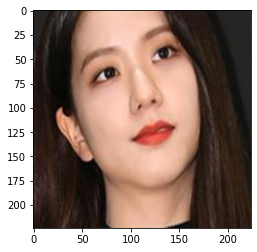

New image prediction :  블랙핑크 지수
accuracy : 0.9999715089797974


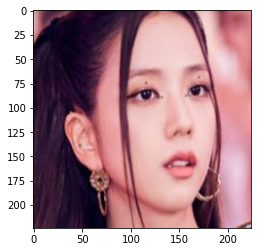

New image prediction :  블랙핑크 지수
accuracy : 0.999297022819519


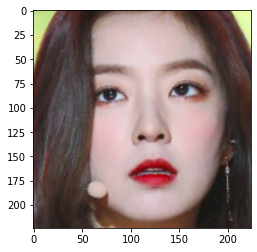

New image prediction :  블랙핑크 로제
accuracy : 0.8825638890266418


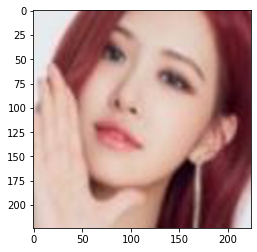

New image prediction :  블랙핑크 제니
accuracy : 0.8333509564399719


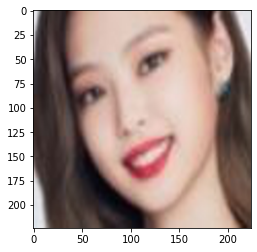

New image prediction :  블랙핑크 지수
accuracy : 0.9997820258140564


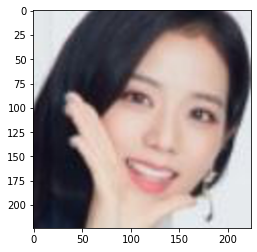

New image prediction :  블랙핑크 리사
accuracy : 0.9966838955879211


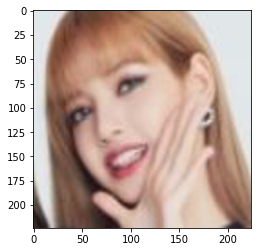

New image prediction :  블랙핑크 제니
accuracy : 0.5640094876289368


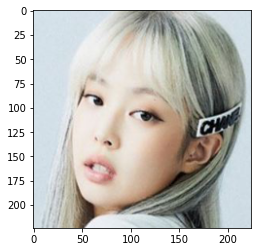

New image prediction :  블랙핑크 로제
accuracy : 0.9539773464202881


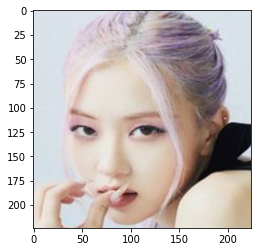

New image prediction :  블랙핑크 지수
accuracy : 0.9999327659606934


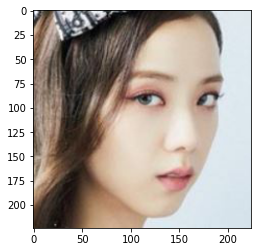

New image prediction :  블랙핑크 리사
accuracy : 0.995671272277832


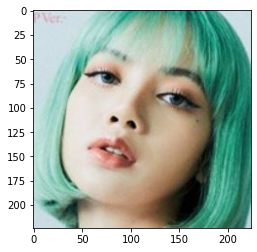

In [53]:
# test 폴더에 있는 이미지를 이용해서 인식 / 분류 실행 
import numpy as np
import matplotlib.image as mpimg
from PIL import Image
from keras.applications.imagenet_utils import preprocess_input
from keras import backend as K
import matplotlib.pyplot as plt
import natsort
%matplotlib inline

targetx = 224
targety = 224

test_dir = os.getcwd()+"/img/test/"
label_dir = os.getcwd()+"/img/label/"
class_list = os.listdir(train_dir)
class_list = natsort.natsorted(class_list)
print(class_list)

image_path = []
for i in os.listdir(test_dir):
    test_image_name = test_dir + i
    image_path.append(test_image_name)  

for image in image_path:
    img = Image.open(image)
    img = img.convert("RGB")
    img = img.resize((targetx,targety))    
    data = np.asarray(img)
    X = np.array(data)
    X = X.astype("float") / 256
    X = X.reshape(-1, targetx, targety,3)
    categories = class_list
    pred = model.predict(X)
    result = [np.argmax(value) for value in pred]   # 예측 값중 가장 높은 클래스 반환
    print('New image prediction : ',categories[result[0]])
    print("accuracy : {}".format(max(pred[0])))
    plt.imshow(img)
    plt.show()

In [85]:
while True:pass

KeyboardInterrupt: ignored